# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Email Spam Classifier

## Overview:
Spam filtering is a binary classification task familiar to any user of email services. I will use machine learning classifiers to implement a similar spam filter.

The task is to distinguish between two types of emails, “spam” and “non-spam” often called “ham”. The machine learning classifier will detect that an email is spam if it is characterised by certain features. The features would be generated based on the textual content of the mail.

## Reference Tutorial:
https://cambridgecoding.wordpress.com/2016/01/25/implementing-your-own-spam-filter/

In [1]:
#Import the libraries
import os
import re
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import operator
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from time import time
from wordcloud import WordCloud

## Reading Data

Apache SpamAssasin public corpus has spam and ham mails data. 
Below is the URL of the corpus data
http://spamassassin.apache.org/old/publiccorpus/ 

While reading the email from corpus file, opening the file with utf8 encoding. If UnicodeDecodeError occurs due to not supported character, we catch the exception and continue reading next file

In [2]:
def init_lists(folder):
    a_list = []
    file_list = os.listdir(folder)
    for a_file in file_list:
        f = open(folder + a_file, 'r')
        try:
            a_list.append(f.read().encode("utf8"))
        except UnicodeDecodeError:
            #print(a_file)
            continue
    f.close()
    return a_list

Read all Spam and Ham Mails and put them in two lists: one for spam mails and other for ham mails

In [3]:
spam1MailList = init_lists('data/20030228_spam/spam/')
spam2MailList = init_lists('data/20050311_spam_2/spam_2/')

easyHam1MailList = init_lists('data/20030228_easy_ham/easy_ham/')
easyHam2MailList = init_lists('data/20030228_easy_ham_2/easy_ham_2/')
hardHamMailList = init_lists('data/20030228_hard_ham/hard_ham/')

spamMailList = spam1MailList + spam2MailList
hamMailList = easyHam1MailList + easyHam2MailList + hardHamMailList

### Spam mail sample : 

In [4]:
spamMailList[120]

b'From jamie@msn.com  Tue Aug 27 14:27:25 2002\nReturn-Path: <jamie@msn.com>\nDelivered-To: zzzz@localhost.spamassassin.taint.org\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id C0CC943F9B\n\tfor <zzzz@localhost>; Tue, 27 Aug 2002 09:27:14 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Tue, 27 Aug 2002 14:27:14 +0100 (IST)\nReceived: from ks1.gayacom.net (co-location.ibsoft.iAsiaWorks.ne.kr\n    [211.36.253.28] (may be forged)) by dogma.slashnull.org (8.11.6/8.11.6)\n    with ESMTP id g7RDRwZ09790 for <zzzz@jmason.org>; Tue, 27 Aug 2002 14:27:58\n    +0100\nReceived: (from nobody@localhost) by ks1.gayacom.net (8.9.3/8.9.3) id\n    WAA15535; Tue, 27 Aug 2002 22:26:56 +0900\nDate: Tue, 27 Aug 2002 22:26:56 +0900\nMessage-Id: <200208271326.WAA15535@ks1.gayacom.net>\nTo: zzzz@spamassassin.taint.org, yyyy@johnmccrory.com, yyyy@judimartindale.com

### Ham mail sample:

In [5]:
hamMailList[10]

b'From spamassassin-devel-admin@lists.sourceforge.net  Thu Aug 22 15:25:29 2002\nReturn-Path: <spamassassin-devel-admin@example.sourceforge.net>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id AE2D043F9B\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 10:25:29 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 15:25:29 +0100 (IST)\nReceived: from usw-sf-list2.sourceforge.net (usw-sf-fw2.sourceforge.net\n    [216.136.171.252]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id\n    g7MENlZ09984 for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 15:23:47 +0100\nReceived: from usw-sf-list1-b.sourceforge.net ([10.3.1.13]\n    helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with\n    esmtp (Exim 3.31-VA-mm2 #1 (Debian)) id 17hsof-00042r-00; Thu,\n    22 Aug 2002 07:20:05 -0700\nRe

## Data Preprocesser Helpers

Implementing a Data Preporcessor helper '**preprocess_normalize**' for following purpose:
    Remove htmls markups
    Normalize numbers, Urls, email address and Dollar sign
      Replace 0-9 with ‘number
      hyperlinks with 'httpaddr'
      Email address with 'emailaddr'
      $ with 'dollar' 

In [6]:
def preprocess_normalize(email):
    # replace html tag
    email = re.sub(r"<[^<>]+>", " ", str(email))

    # replace 0-9 with number 
    email = re.sub(r"[0-9]+", "number", email)


    # replace hyperlinks with 'httpaddr'
    email = re.sub(r"(http|https)://[^\s]*", "httpaddr", email)


    # replace any email address with 'emailaddr'
    email = re.sub(r"[^\s]+@[^\s]+", "emailaddr", email) 

    # replace $ with 'dollar'
    email = re.sub(r"[$]+", "dollar", email) 
    
    return email

Implementing a Data Preporcessor helper '**preprocess_lemmatize_tokenize**' for following tasks
    Tokenize the words
    Take only alphanumeric words,
    Filter stop words (words which do not have significance like : to, the, a etc
    Lemmatize and change case to lower to reduce the words to their stemmed form

In [7]:
stoplist = stopwords.words('english')

def preprocess_lemmatize_tokenize(email):
    #tokenize
    tokens = word_tokenize(email)

    #take only alphanumeric
    alphaNumericTokens =  [word for word in tokens if word.isalpha()]

    #filter stoplist words
    nonStoplistWords =  [word for word in alphaNumericTokens if not word in stoplist]

    #lemmatize and change case to lower
    lemmatizedAlphaNumericTokens = [WordNetLemmatizer().lemmatize(word.lower()) for word in nonStoplistWords]

    #filter stoplist words
    return lemmatizedAlphaNumericTokens

Implement a custom tokenizer LemmatizerTokenizer which will use preprocess_lemmatize_tokenize defined earlier for data preprocessing steps. This custom tokenizer class will be used in TfidfVectorizer later during feature extraction

In [8]:
class LemmatizerTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()
        def __call__(self, doc):
            return preprocess_lemmatize_tokenize(doc)

## Data Exploration and  Visualization

In [9]:
print("Number of Spam mails : {}".format(len(spamMailList)))
print("Number of Ham mails : {}".format(len(hamMailList)))

print("Percentage of spam mails : {:.2f} %".format((float(len(spamMailList))/ (len(spamMailList) + len(hamMailList)))*100))

Number of Spam mails : 1889
Number of Ham mails : 4153
Percentage of spam mails : 31.26 %


In [10]:
def preprocess_visuals(email):
    # normalize
    email = preprocess_normalize(email)
    
    #lemmatize and Tockenize
    return preprocess_lemmatize_tokenize(email)

def get_wordFrequency(words):
    return {word: count for word, count in Counter(words).items()}

Processing email text to get the unique word and its occurance count in Spam and Ham mails. While processing we are using the same logic to Normalize, Tockenize and Lemmatize, which will be used during feature extraction while training the classifiers.

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\ProgramData\Anaconda3\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
processedSpamMailList = [preprocess_visuals(email)for email in spamMailList]
processedHamMailList = [preprocess_visuals(email)for email in hamMailList]

spamMailWordFrequencyList = [get_wordFrequency(words) for words in processedSpamMailList]
hamMailWordFrequencyList = [get_wordFrequency(words) for words in processedHamMailList]

allSpamWordFrequency = dict(sum((Counter(x) for x in spamMailWordFrequencyList),Counter()))
allHamWordFrequency = dict(sum((Counter(x) for x in hamMailWordFrequencyList),Counter()))

In [13]:
print("Total Word Count in Spam mail Words : {}".format(len(allSpamWordFrequency)))
print("Total Word Count in Ham mails Words : {}".format(len(allHamWordFrequency)))

Total Word Count in Spam mail Words : 18569
Total Word Count in Ham mails Words : 38367


Processed spam mail sample

In [14]:
print(processedSpamMailList[120],)

['emailaddr', 'tue', 'aug', 'number', 'number', 'number', 'number', 'emailaddr', 'localhost', 'localhost', 'postfix', 'esmtp', 'id', 'tue', 'number', 'aug', 'number', 'number', 'number', 'number', 'edt', 'phobos', 'localhost', 'imap', 'emailaddr', 'tue', 'number', 'aug', 'number', 'number', 'number', 'number', 'ist', 'may', 'forged', 'esmtp', 'id', 'gnumberrdrwznumber', 'tue', 'number', 'aug', 'number', 'number', 'number', 'emailaddr', 'waanumber', 'tue', 'number', 'aug', 'number', 'number', 'number', 'number', 'tue', 'number', 'aug', 'number', 'number', 'number', 'number', 'emailaddr', 'emailaddr', 'emailaddr', 'emailaddr', 'emailaddr', 'emailaddr', 'emailaddr', 'emailaddr', 'emailaddr', 'www', 'form', 'result', 'feedback', 'form', 'it', 'submitted', 'emailaddr', 'tuesday', 'august', 'number', 'number', 'number', 'number', 'click', 'want', 'pay', 'porn', 'would', 'like', 'get', 'free', 'the', 'honest', 'no', 'risk', 'number', 'free', 'way', 'if', 'take', 'couple', 'minute', 'read', 's

Processed ham mail sample

In [15]:
print(processedHamMailList[10],)

['emailaddr', 'thu', 'aug', 'number', 'number', 'number', 'number', 'emailaddr', 'localhost', 'localhost', 'postfix', 'esmtp', 'id', 'thu', 'number', 'aug', 'number', 'number', 'number', 'number', 'edt', 'phobos', 'localhost', 'imap', 'emailaddr', 'thu', 'number', 'aug', 'number', 'number', 'number', 'number', 'ist', 'esmtp', 'gnumbermenlznumber', 'thu', 'number', 'aug', 'number', 'number', 'number', 'number', 'esmtp', 'exim', 'number', 'debian', 'id', 'thu', 'number', 'aug', 'number', 'number', 'number', 'number', 'esmtp', 'exim', 'number', 'debian', 'thu', 'number', 'aug', 'number', 'number', 'number', 'number', 'authenticated', 'esmtp', 'id', 'gnumbermeinumbervpnumber', 'thu', 'number', 'aug', 'number', 'number', 'number', 'david', 'b', 'nothing', 'found', 'sadev', 'interesting', 'approach', 'spam', 'emailaddr', 'emailaddr', 'emailaddr', 'spamassassin', 'developer', 'thu', 'number', 'aug', 'number', 'number', 'number', 'number', 'thu', 'number', 'aug', 'number', 'number', 'number', 

### Word Cloud Visualization
Word cloud (tag cloud, or weighted list in visual design) is a visual representation of text data. Tags are usually single words, and the importance of each tag is shown with font size or color, which gives greater prominence to words that appear more frequently. Two separate word cloud map is created for spam and ham words. This visualization makes it easier to see relative frequency of words in spam and ham mails

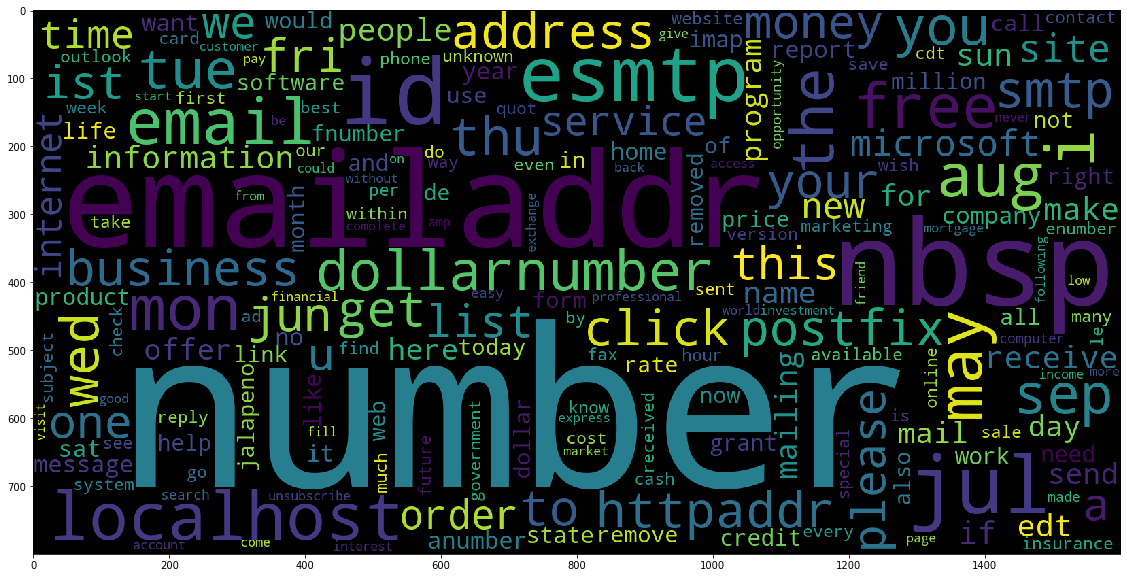

In [16]:
wcSpam = WordCloud(width=1600, height=800).generate_from_frequencies(allSpamWordFrequency)
matplotlib.pyplot.figure( figsize=(20,10) )
matplotlib.pyplot.imshow(wcSpam)
matplotlib.pyplot.show()

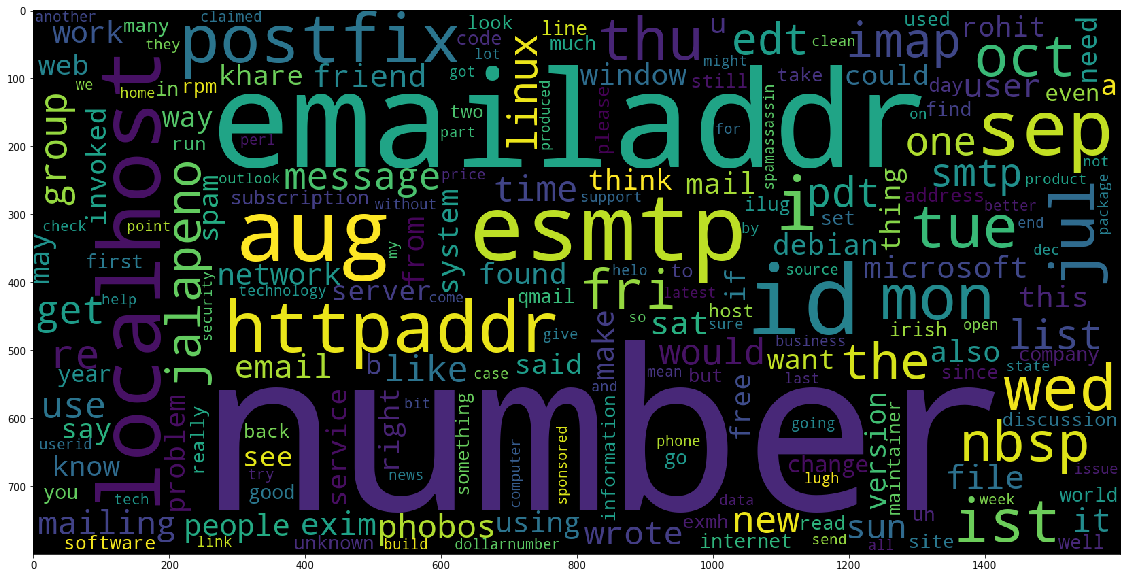

In [17]:
wcHam = WordCloud(width=1600, height=800).generate_from_frequencies(allHamWordFrequency)
matplotlib.pyplot.figure( figsize=(20,10) )
matplotlib.pyplot.imshow(wcHam)
matplotlib.pyplot.show()

### Frequency Histogram: 

100 most frequent word and its frequency is plotted for spam email words and ham email words. Y axis has frequency count of top 100 high frequency words and X-axis has the corresponding word.  This plot helps in visualizing the actual frequency of words in spam and ham mails

In [18]:
sorted_allSpamWordFrequency = sorted(allSpamWordFrequency.items(), key=operator.itemgetter(1), reverse=True)
sorted_allHamWordFrequency = sorted(allHamWordFrequency.items(), key=operator.itemgetter(1), reverse=True)

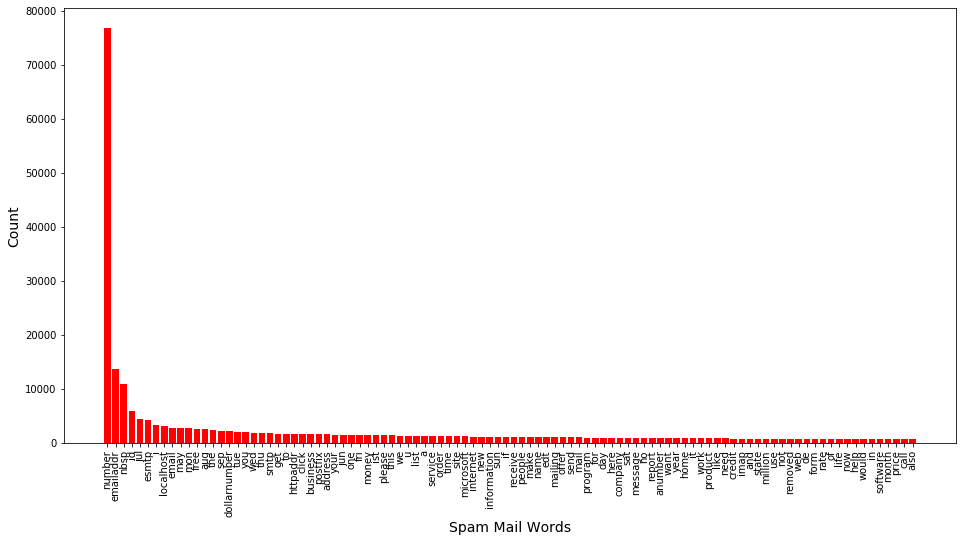

In [19]:
#Plot Top 100 SPAM word and its frequency
dataLength = len(sorted_allSpamWordFrequency) if len(sorted_allSpamWordFrequency)<100 else 100
spamWords, spamWordsFrequency = zip(*sorted_allSpamWordFrequency[0:dataLength])

x_pos = np.arange(dataLength) 

plt.figure(figsize=(16, 8))
plt.bar(x_pos, spamWordsFrequency,color='r')
plt.xticks(x_pos, spamWords, rotation='vertical') 
plt.xlabel("Spam Mail Words", fontsize=14)  
plt.ylabel("Count", fontsize=14)
plt.show()

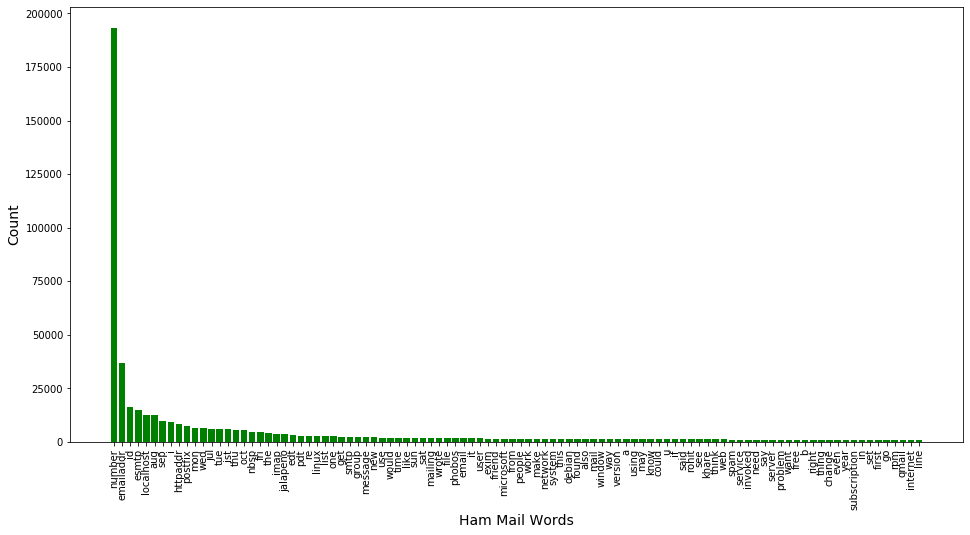

In [20]:
#Plot Top 100 HAM word and its frequency
dataLength = len(sorted_allHamWordFrequency) if len(sorted_allHamWordFrequency)<100 else 100
hamWords, hamWordsFrequency = zip(*sorted_allHamWordFrequency[0:dataLength])

x_pos = np.arange(dataLength) 

plt.figure(figsize=(16, 8))
plt.bar(x_pos, hamWordsFrequency,color='g')
plt.xticks(x_pos, hamWords, rotation='vertical') 
plt.xlabel("Ham Mail Words", fontsize=14)  
plt.ylabel("Count", fontsize=14)
plt.show()

# Data Processing

In this section, we will prepare the data for modeling, training and testing. We are also using sklearn.feature_extraction.text TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features.

In [21]:
emailtext = [ preprocess_normalize(email)for email in spamMailList]
y = [1 for email in spamMailList]

emailtext = emailtext + [ preprocess_normalize(email)for email in hamMailList]
y = y + [0 for email in hamMailList]

In [22]:
#Shuffle and split the dataset into the number of training and testing points
X_train,X_test,y_train,y_test = train_test_split(emailtext, y, test_size=0.2, random_state=3)

# Initialize the vectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', use_idf=True ,tokenizer= LemmatizerTokenizer())

## Training and Evaluation
In this section we are training and testing different supervised learning models and evaluate there performance 

A helper function train_predict is implemented   for  training and testing different supervised learning models. 
The function takes as input a classifier, and the training and testing data. It creates a sklearn pipeline using the vectorizer created in data processing step. Using this pipeline, the model is trained.

#### Scorer Funcion:
In the given dataset, the spam ratio is 31% only. For such problem f1score is a better metric to analyse performance of a classifier since Classification accuracy not enough to measure accuracy of a classifier.

In [23]:
from sklearn.preprocessing import FunctionTransformer

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    pipeline = make_pipeline(vectorizer, FunctionTransformer(lambda x: x.todense(), accept_sparse=True),  clf)
    
    print ("Training Classifier : {} on a training set size of {} . . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    start_Train = time()
    pipeline.fit(X_train, y_train)
    end_Train = time()
    
    # Predict from trained classifier on train set    
    y_pred_train = pipeline.predict(X_train)
    
    # Predict from trained classifier on test set
    start_Pred_test = time()
    y_pred_test = pipeline.predict(X_test)
    end_Pred_test = time()
    
    #calculate f1 score
    f1socre_train = f1_score(y_train, y_pred_train, pos_label=1)
    f1socre_test = f1_score(y_test, y_pred_test, pos_label=1)
    
    # Print the f1 score
    print ("Training Time: {:.3f} , Prediction Time : {:.3f} , f1 score (training) : {:.4f} , f1 score (testing) : {:.4f}".format(end_Train - start_Train, end_Pred_test -start_Pred_test , f1socre_train, f1socre_test))

Training DataSet is trimmed into different sizes to be used during model evaluation

In [24]:
#Set up the training set sizes
dataSize = len(X_train)
X_train_25 = X_train[:int(dataSize * .25)]
y_train_25 = y_train[:int(dataSize * .25)]

X_train_50 = X_train[:int(dataSize * .5)]
y_train_50 = y_train[:int(dataSize * .5)]

X_train_75 = X_train[:int(dataSize * .75)]
y_train_75 = y_train[:int(dataSize * .75)]

Training sklearn DummyClassifier to be used as baseline to compare with other classifiers. DummyClassifier makes predictions using simple rules

In [25]:
# train a DummyClassifier to be used as baseline
from sklearn.dummy import DummyClassifier

clf_baseline =  DummyClassifier()

train_predict(clf_baseline, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_baseline, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_baseline, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_baseline, X_train, y_train, X_test, y_test)

Training Classifier : DummyClassifier on a training set size of 1208 . . .


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Training Time: 566.411 , Prediction Time : 101.052 , f1 score (training) : 0.2756 , f1 score (testing) : 0.3005
Training Classifier : DummyClassifier on a training set size of 2416 . . .


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Training Time: 732.835 , Prediction Time : 100.795 , f1 score (training) : 0.3085 , f1 score (testing) : 0.3147
Training Classifier : DummyClassifier on a training set size of 3624 . . .


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Training Time: 2136.585 , Prediction Time : 101.728 , f1 score (training) : 0.3010 , f1 score (testing) : 0.3129
Training Classifier : DummyClassifier on a training set size of 4833 . . .


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Training Time: 3279.638 , Prediction Time : 100.905 , f1 score (training) : 0.3136 , f1 score (testing) : 0.3087


In this section, I will choose 4 supervised learning models that are appropriate for this problem and available in scikit-learn. We will then fit the model to varying sizes of training data  and measure the F1 score.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

#Initialize the  models

clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=3)
clf_C = KNeighborsClassifier()
clf_D = svm.LinearSVC(random_state=3)

# Execute the 'train_predict' function for each classifier and each training set size
train_predict(clf_A, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_A, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_A, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_A, X_train, y_train, X_test, y_test)

train_predict(clf_B, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_B, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_B, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_B, X_train, y_train, X_test, y_test)

train_predict(clf_C, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_C, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_C, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_C, X_train, y_train, X_test, y_test)

train_predict(clf_D, X_train_25, y_train_25, X_test, y_test)
train_predict(clf_D, X_train_50, y_train_50, X_test, y_test)
train_predict(clf_D, X_train_75, y_train_75, X_test, y_test)
train_predict(clf_D, X_train, y_train, X_test, y_test)

Training Classifier : GaussianNB on a training set size of 1208 . . .
Training Time: 563.625 , Prediction Time : 101.282 , f1 score (training) : 0.9973 , f1 score (testing) : 0.8195
Training Classifier : GaussianNB on a training set size of 2416 . . .
Training Time: 745.116 , Prediction Time : 101.775 , f1 score (training) : 0.9987 , f1 score (testing) : 0.8432
Training Classifier : GaussianNB on a training set size of 3624 . . .
Training Time: 2129.144 , Prediction Time : 101.640 , f1 score (training) : 0.9987 , f1 score (testing) : 0.8796
Training Classifier : GaussianNB on a training set size of 4833 . . .
Training Time: 3317.674 , Prediction Time : 102.003 , f1 score (training) : 0.9987 , f1 score (testing) : 0.8926
Training Classifier : LogisticRegression on a training set size of 1208 . . .
Training Time: 562.869 , Prediction Time : 99.921 , f1 score (training) : 0.8915 , f1 score (testing) : 0.8717
Training Classifier : LogisticRegression on a training set size of 2416 . . .
Tra

#### Tabular Representation of Model's Performance

** Classifer 1 - GaussianNB **  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 1208              |        563.625          |      101.282           |      0.9973      |     0.8195      |
| 2216              |        745.116          |      101.775           |      0.9987      |     0.8432      |
| 3624              |        2129.144         |      101.640           |      0.9987      |     0.8796      |
| 4833              |        3317.674         |      102.033           |      0.9987      |     0.8926      |

** Classifer 2 - LogisticRegression**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 1208              |        562.869          |      99.921            |      0.8915      |     0.8717      |
| 2216              |        730.136          |      100.318           |      0.9241      |     0.9220      |
| 3624              |        2121.438         |      100.204           |      0.9398      |     0.9276      |
| 4833              |        3235.752         |      101.185           |      0.9481      |     0.9348      |

** Classifer 3 - KNeighborsClassifier**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 1208              |        562.466          |      145.419           |      0.8384      |     0.7569      |
| 2216              |        737.632          |      234.933           |      0.8823      |     0.8037      |
| 3624              |        2130.281         |      335.584           |      0.8828      |     0.8160      |
| 4833              |        3302.774         |      479.244           |      0.8117      |     0.7534      |

** Classifer 4 - LinearSVC **  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------:  | :-------------:|
| 1208              |        562.789          |      100.029           |      0.9946      |     0.9530      |
| 2216              |        728.364          |      100.347           |      0.9959      |     0.9730      |
| 3624              |        2119.104         |      101.484           |      0.9973      |     0.9795      |
| 4833              |        3244.224         |      101.099           |      0.9970      |     0.9808      |


### Result

In the above table, we can see that KNeighborsClassifier is very slow. 
Gaussian Naïve Bayes and Logistic Regression Classifier are having similar training time and prediction time, but Logistic Regression Classifiers has higher score.

Overall **LinearSVC model seems to be the best classifier**, because the model is giving the highest testing F1 score among the other models. Training and prediction time is also comparable to Logistic Regression and GaussianNB models in this experiment.